InSet Lexicon Head:
   Positive Words            Negative Words
0   word\tweight              word\tweight
1         hai\t3    putus tali gantung\t-2
2     merekam\t2               gelebah\t-2
3   ekstensif\t3            gobar hati\t-2
4   paripurna\t1  tersentuh (perasaan)\t-1
Kata yang paling sering dinormalisasi:
 [('aja', 7), ('sya', 7), ('ga', 6), ('udah', 4), ('gak', 4), ('k', 3), ('gaada', 3), ('rb', 3), ('pake', 2), ('nggak', 2)]
Kata yang tidak ditemukan pada corpus bahasa Indonesia dan tidak ditemukan pada kamus colloquial:
 [('aplikasi', 10), ('data', 9), ('bank', 6), ('masuk', 6), ('allo', 6), ('promo', 6), ('nya', 5), ('tolong', 5), ('kecewa', 5), ('apk', 4)]
Google Playstore Reviews Sentiment Analysis:
                                              Kalimat Sentimen  Positif  \
0  parah tarik tunai bank mega uang enggak notif ...   Netral        0   
1  kecewa banget aplikasi terdeteksi wajah pin ok...   Netral        0   
2  daftar kagak masuk masuk sinyal saja sudah pak..

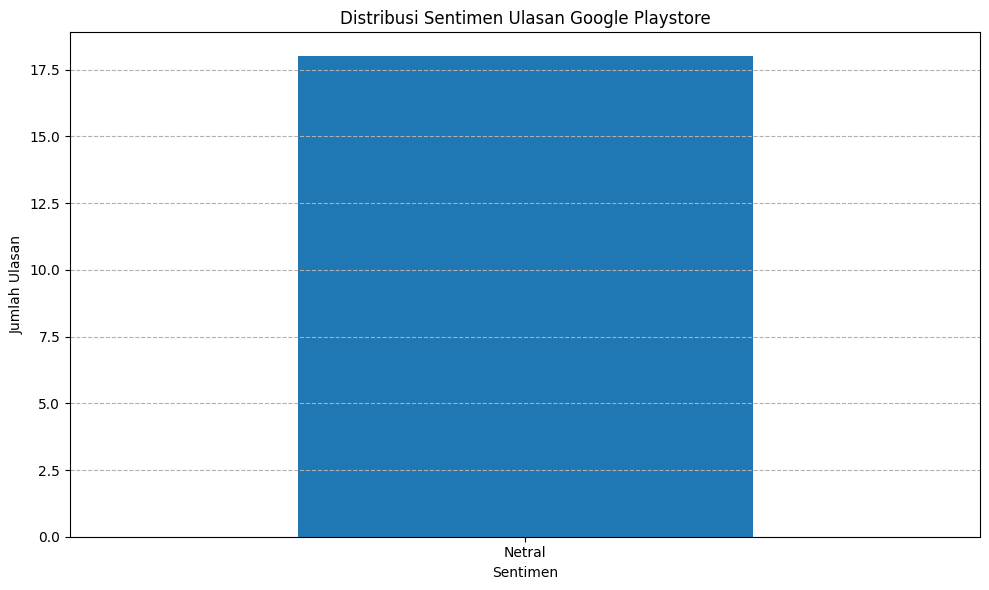

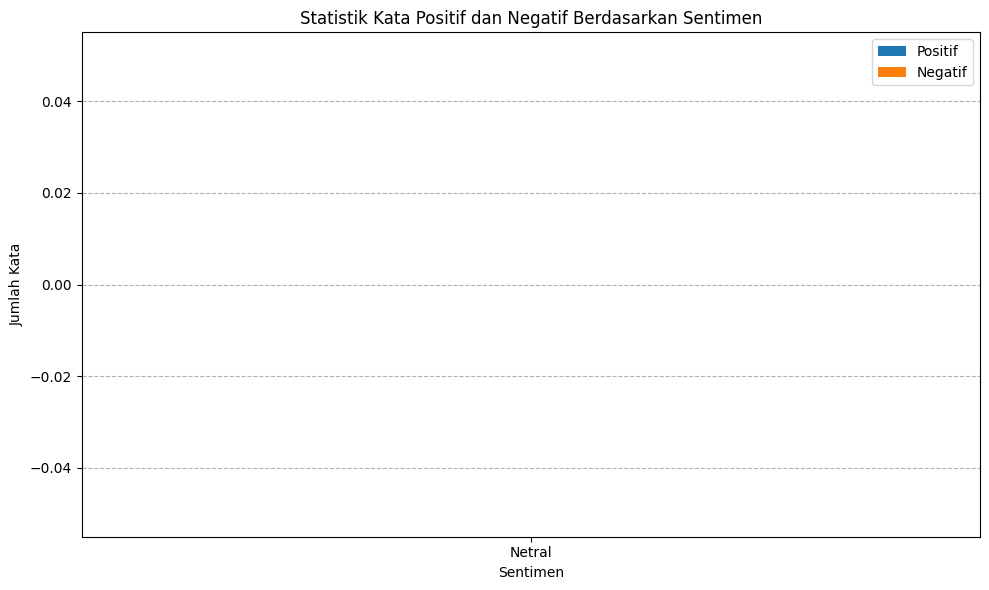

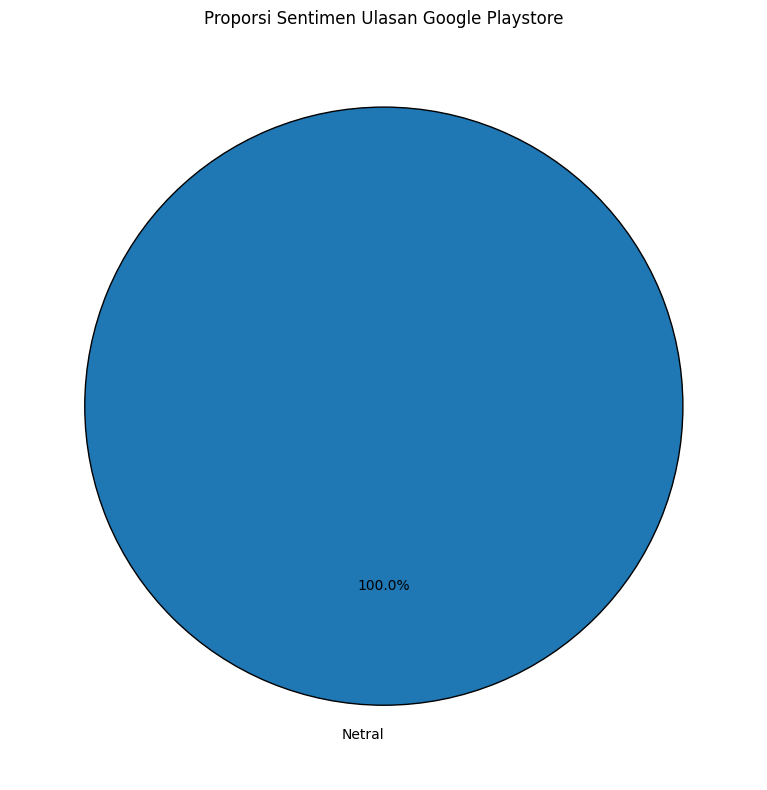

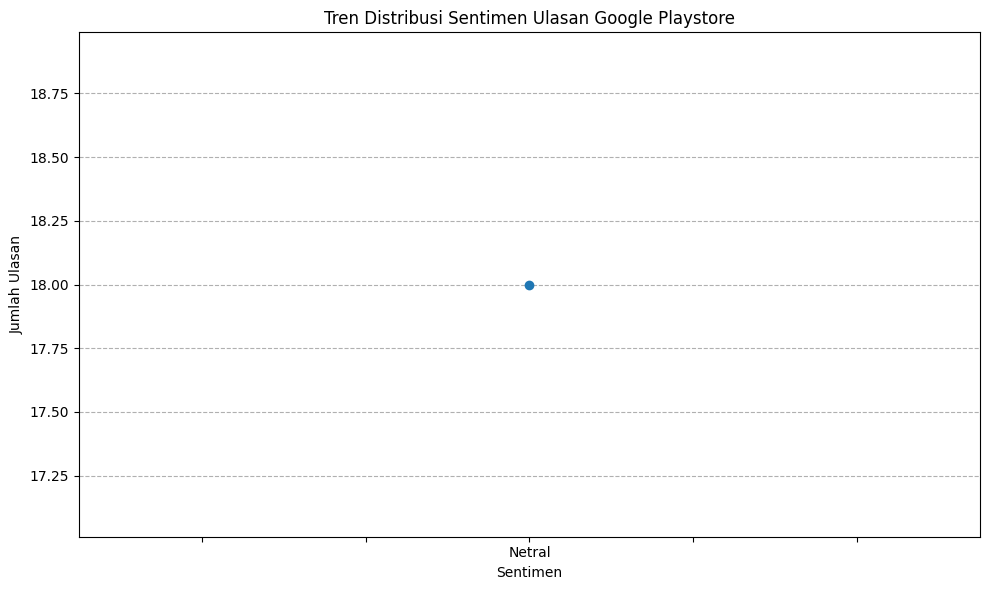

In [1]:
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
from collections import Counter

# Load lexicon data from InSet
positive_url = 'https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv'
negative_url = 'https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv'

# Load positive and negative words from URLs
positive_words = requests.get(positive_url).text.splitlines()
negative_words = requests.get(negative_url).text.splitlines()

# Create lexicon from InSet data
lexicon = {
    'positif': positive_words,
    'negatif': negative_words
}

# Load colloquial lexicon for normalization
colloquial_url = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
colloquial_df = pd.read_csv(colloquial_url)
colloquial_dict = dict(zip(colloquial_df['slang'], colloquial_df['formal']))

# Display InSet data in DataFrame
inset_df = pd.DataFrame({
    'Positive Words': positive_words[:10],
    'Negative Words': negative_words[:10]
})
print("InSet Lexicon Head:\n", inset_df.head())

# Load Google Playstore review data from CSV file
csv_file_path = 'BankDigital/dataset/Sample400Dataset.csv'  # Update with the actual path to your CSV file
reviews_df = pd.read_csv(csv_file_path)

# Extract cleaned_content column for sentiment analysis
reviews = reviews_df['cleaned_content'].dropna().tolist()

# Function to normalize slang words using colloquial dictionary
def normalize_text(text, colloquial_dict):
    words = text.split()
    normalized_words = [colloquial_dict.get(word, word) for word in words]
    return ' '.join(normalized_words), words, normalized_words

# Normalize reviews and collect normalization statistics
total_reviews = len(reviews)
normalized_reviews = []
normalization_counter = Counter()
not_found_words = Counter()

for review in reviews:
    normalized_text, original_words, normalized_words = normalize_text(review, colloquial_dict)
    normalized_reviews.append(normalized_text)
    for word, normalized_word in zip(original_words, normalized_words):
        if word != normalized_word:
            normalization_counter[word] += 1
        if word not in lexicon['positif'] and word not in lexicon['negatif'] and word not in colloquial_dict:
            not_found_words[word] += 1

# Display top 10 most normalized words
most_common_normalized = normalization_counter.most_common(10)
print("Kata yang paling sering dinormalisasi:\n", most_common_normalized)

# Display top 10 words not found in both lexicon and colloquial dictionary
most_common_not_found = not_found_words.most_common(10)
print("Kata yang tidak ditemukan pada corpus bahasa Indonesia dan tidak ditemukan pada kamus colloquial:\n", most_common_not_found)

# Sentiment Analysis Function
def sentiment_analysis(data, lexicon):
    results = []
    for sentence in data:
        # Preprocess the sentence
        sentence_clean = re.sub(r'[^a-zA-Z\s]', '', sentence.lower())
        words = sentence_clean.split()
        
        # Initialize counters
        positive_count = 0
        negative_count = 0
        
        # Count sentiment words
        for word in words:
            if word in lexicon['positif']:
                positive_count += 1
            elif word in lexicon['negatif']:
                negative_count += 1
        
        # Determine sentiment
        if positive_count > negative_count:
            sentiment = 'Positif'
        elif negative_count > positive_count:
            sentiment = 'Negatif'
        else:
            sentiment = 'Netral'
        
        # Append result
        results.append({'Kalimat': sentence, 'Sentimen': sentiment, 'Positif': positive_count, 'Negatif': negative_count})
    
    return pd.DataFrame(results)

# Run sentiment analysis on normalized reviews
results_df = sentiment_analysis(normalized_reviews, lexicon)

# Display results
print("Google Playstore Reviews Sentiment Analysis:\n", results_df.head())

# Calculate and display word statistics
results_df['Total Words'] = results_df['Kalimat'].apply(lambda x: len(x.split()))
word_statistics = results_df[['Sentimen', 'Positif', 'Negatif']].groupby('Sentimen').sum()
print("Statistik Kata Berdasarkan Sentimen:\n", word_statistics)

# Visualize sentiment results (Bar Chart)
sentiment_counts = results_df['Sentimen'].value_counts()
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar')
plt.title('Distribusi Sentimen Ulasan Google Playstore')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('sentiment_distribution_bar_chart.png')
plt.show()

# Visualize word statistics (Stacked Bar Chart)
word_statistics[['Positif', 'Negatif']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Statistik Kata Positif dan Negatif Berdasarkan Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Kata')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('word_statistics_stacked_bar_chart.png')
plt.show()

# Visualize sentiment results (Pie Chart)
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Proporsi Sentimen Ulasan Google Playstore')
plt.ylabel('')
plt.tight_layout()
plt.savefig('sentiment_distribution_pie_chart.png')
plt.show()

# Visualize sentiment results (Line Chart)
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='line', marker='o')
plt.title('Tren Distribusi Sentimen Ulasan Google Playstore')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('sentiment_distribution_line_chart.png')
plt.show()